# multithreaded vs. asyncio access

A few considerations for concurrent network access of multiband COGs

Goal: read all the data in a COG from *network blob storage* with max throughput from a single machine with multiple CPUs

Inspired by https://github.com/corteva/rioxarray/blob/master/docs/examples/read-locks.ipynb

In [1]:
# These are the resources of the node we're runnning on
import psutil
print('physical cores:', psutil.cpu_count(logical=False))
print('vCPU:', psutil.cpu_count())

physical cores: 4
vCPU: 8


In [2]:
# But on a JupyterHub / k8s deployment you might not have full access to those resources
# (For multithreaded access, generally want to n_threads < 2xCPU)
!printenv | grep LIMIT

MEM_LIMIT=7516192768
CPU_LIMIT=4.0


## part 1) threads

By default Dask and Xarray use multiple threads for concurrency. The basic idea being that it should be faster to simultaneously retrieve a COG divided into 4 sections compared to a single request for all the data.

In [3]:
# GDAL Settings
import os
env = dict(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR', 
           GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
           GDAL_SWATH_SIZE='200000000',
           VSI_CURL_CACHE_SIZE='200000000',
          )
os.environ.update(env)

In [4]:
# For max efficiency, you have to align dask chunks with data layout
# https://docs.dask.org/en/latest/array-chunks.html

# How to we know the layout of a COG? you have to read the metadata to find out:
import rasterio
print(rasterio.__version__)
url_http = "https://naipeuwest.blob.core.windows.net/naip/v002/md/2013/md_100cm_2013/39076/m_3907617_ne_18_1_20130924.tif"
with rasterio.open(url_http) as src:
    metadata = src.profile

1.2.0


In [5]:
# NOTE: this example uses a pretty large COG (197MB) in another datacenter (Azure)
# pulling the data to the local disk takes ~37s (~5MB/s) on a this M5.2xlarge AWS instance...
#!curl -O {url_http}

**The profile information above has some important info for Dask:**
1. `count=4`. this is the number of bands (R,G,B,NIR)
2. `interleave=pixel`. this is how the data arrays are flattened and stored in memory/on disk
3. `blockxsize=blockysize=512`. this is a common value for internal tiling of the cog.
    This is the atomic value of a read request, even if you want the value of a single pixel, you're going to read 512x512 of them.
    
    
Note that a single-band COG is typically stored like this, such that reading information across rows is most efficient. This is because behind the scenes GDAL merged consecutive byte ranges. In this specific example, if we ask to compute the mean of the first row, we don't have 6106/512 GET requests, instead the adjacent tiles are retrieved in a single GET request. For network access, it's best to limit the number of server requests.

So in practice, specify dask chunks like `chunks = dict(x=-1, y="auto")` which means read at least an entire row, up to `N` rows determined by the config setting `dask.config.set({"array.chunk-size":"64MiB"})` (128MiB by default):
![single-band](images/single-band.png)


With more than one band you have options for how the data is stored, and *in this case we have 4 bands interleaved by pixel*. Here we want to ensure all bands are read together across a row, so `chunks = dict(band=-1, x=-1, y="auto")`
![BIP](images/BIP.png)


Read more here https://desktop.arcgis.com/en/arcmap/10.3/manage-data/raster-and-images/bil-bip-and-bsq-raster-files.htm

In [6]:
import rioxarray
print(rioxarray.__version__)
ds = rioxarray.open_rasterio(url_http, lock=False, chunks = dict(band=-1, x=-1, y="auto"))
ds

0.2.0


<xarray.DataArray (band: 4, y: 7652, x: 6106)>
dask.array<open_rasterio-7b0eab2ae3454044fed08ad25807ee72<this-array>, shape=(4, 7652, 6106), dtype=uint8, chunksize=(4, 3826, 6106), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 4
  * y            (y) float64 4.402e+06 4.402e+06 ... 4.394e+06 4.394e+06
  * x            (x) float64 3.336e+05 3.336e+05 ... 3.397e+05 3.397e+05
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

In [7]:
# It's always good to inspect the HTML display of the data we have loaded. In this case our default settings have divided the
# COG into just two chunks. This is important because if we request more than two threads to work with this dataset we are not
# going to see much benefit. So instead you might force the data into more chunks:
ds = ds.chunk(dict(band=-1, x=-1, y=int(ds.y.size/8)))
ds

<xarray.DataArray (band: 4, y: 7652, x: 6106)>
dask.array<rechunk-merge, shape=(4, 7652, 6106), dtype=uint8, chunksize=(4, 956, 6106), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 4
  * y            (y) float64 4.402e+06 4.402e+06 ... 4.394e+06 4.394e+06
  * x            (x) float64 3.336e+05 3.336e+05 ... 3.397e+05 3.397e+05
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

## part 2) asynchronous requests

Multithreaded access is pretty easy to implement, but comes with some drawbacks. In particular the need for a machine with multiple CPUs to realize any benefit.

An alternative strategy is asynchronous code, which uses co-routines instead of worker threads for concurrency. https://docs.python.org/3/library/asyncio.html . Code must be written differently for asyncio, fortunately there is this nice lightweight library (https://pypi.org/project/aiocogeo/) specifically for async COG reading! 

In [8]:
# https://pypi.org/project/aiocogeo/ #v0.3.0 currently
#!pip install aiocogeo
from aiocogeo import COGReader

In [9]:
#%%time time magics mess with async code
import time

# IMPORTANT: aiocogeo bypasses GDAL and returns metadata and numpy arrays, how to integrate with Xarray?
# ALSO, needs a bit of work for non-integer type COGs https://github.com/geospatial-jeff/aiocogeo/issues/107

# Wall time: 5.56s
# subsequent time improved due to caching: 2.45s

async def fetch_array(url):
    async with COGReader(url) as cog:
        bounds = cog.native_bounds
        shape = (cog.profile['width'], cog.profile['height'])
        print(bounds, shape)
        data = await cog.read(bounds=bounds, shape=shape)
        
        return data

start_time = time.time()
data = await fetch_array(url_http)
elapsed_time = (time.time() - start_time)
print(f'Wall time: {elapsed_time:.2f}s') 

(333558.0, 4394454.0, 339664.0, 4402106.0) (6106, 7652)
Wall time: 5.22s


In [10]:
# Now a quick test of reading this data with different numbers of threads

# QUESTION: is this code being as efficient as possible with re-using the HTTP server 'session'?

# NOTE: single timing blocks not great for benchmarking, it seems like sometimes server hangs...
#timings = [47.37379288673401, 35.61389136314392, 137.22788500785828, 8.491714239120483, 10.923977613449097] #nchunks=8
import dask
print(dask.__version__)

threads=[1,2,4,8,16]
timings = []
for n in threads:
    with dask.config.set({'scheduler':'threads', 'num_workers':n}):
        start_time = time.time()
        da = rioxarray.open_rasterio(url_http, lock=False, chunks=dict(band=-1, x=-1, y=956)) #y=height/8
        da.compute()
        elapsed_time = (time.time() - start_time)
        timings.append(elapsed_time)
#timings

2021.01.1


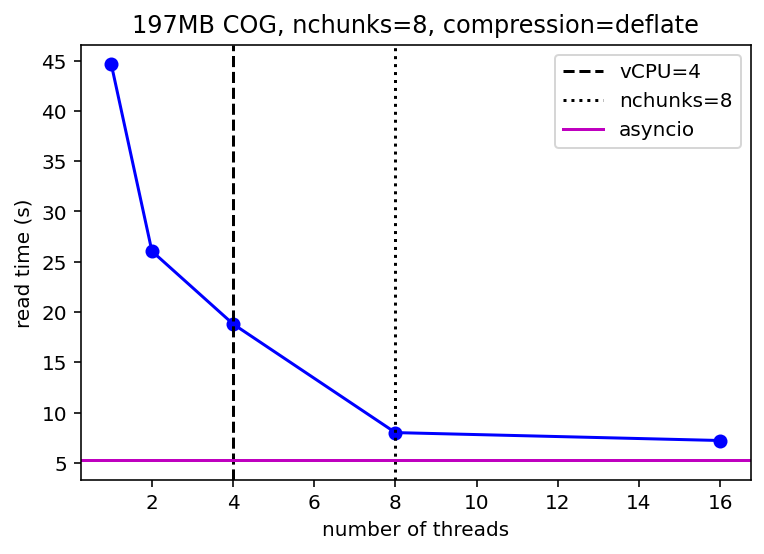

In [11]:
# In summary
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

# Single run of this notebook (chunks=4)
#[32.54628348350525, 17.718342065811157, 11.342740058898926, 16.732646703720093, 11.160630464553833]
# chunks=8
timings = [44.61565446853638, 26.049444675445557, 18.80831289291382, 8.008028268814087, 7.221931457519531]
#timings = [38.838658571243286, 24.692053079605103, 14.271094560623169, 8.013622760772705, 18.465515851974487]
#timings = [44.985893964767456, 20.10182547569275, 12.991515159606934, 9.86700987815857, 7.074400424957275]

plt.plot(threads, timings, 'bo-')
plt.xlabel('number of threads')
plt.ylabel('read time (s)')
plt.axvline(4, color='k', linestyle='dashed', label='vCPU=4')
plt.axvline(8, color='k', linestyle='dotted', label='nchunks=8')
plt.axhline(5.3, color='m', label='asyncio')
plt.title('197MB COG, nchunks=8, compression=deflate')
plt.legend();

- align data structure (band interleaving) with dask chunking for best performance
- asyncio reading can faster than multithreading and doesn't require multiple CPUs. 
    - unsure how to best integrate asyncio with xarray/rioxarray though